# PATH WAYPOINTS AS PARAMETRIZED CURVE

In [10]:
import numpy as np
from scipy.interpolate import interp1d

def compute_path_from_wp(start_xp, start_yp, step = 0.1):
    final_xp=[]
    final_yp=[]
    delta = step #[m]

    for idx in range(len(start_xp)-1):
        section_len = np.sum(np.sqrt(np.power(np.diff(start_xp[idx:idx+2]),2)+np.power(np.diff(start_yp[idx:idx+2]),2)))

        interp_range = np.linspace(0,1,np.floor(section_len/delta).astype(int))
        
        fx=interp1d(np.linspace(0,1,2),start_xp[idx:idx+2],kind=1)
        fy=interp1d(np.linspace(0,1,2),start_yp[idx:idx+2],kind=1)
        
        final_xp=np.append(final_xp,fx(interp_range))
        final_yp=np.append(final_yp,fy(interp_range))

    return np.vstack((final_xp,final_yp))

def get_nn_idx(state,path):

    dx = state[0]-path[0,:]
    dy = state[1]-path[1,:]
    dist = np.sqrt(dx**2 + dy**2)
    nn_idx = np.argmin(dist)

    try:
        v = [path[0,nn_idx+1] - path[0,nn_idx],
             path[1,nn_idx+1] - path[1,nn_idx]]   
        v /= np.linalg.norm(v)

        d = [path[0,nn_idx] - state[0],
             path[1,nn_idx] - state[1]]

        if np.dot(d,v) > 0:
            target_idx = nn_idx
        else:
            target_idx = nn_idx+1

    except IndexError as e:
        target_idx = nn_idx

    return target_idx

In [11]:
#define track
wp=np.array([0,5,6,10,11,15, 0,0,2,2,0,4]).reshape(2,-1)
track = compute_path_from_wp(wp[0,:],wp[1,:],step=0.5)

#vehicle state
state=[3.5,0.5,np.radians(30)]

#given vehicle pos find lookahead waypoints
nn_idx=get_nn_idx(state,track)-1 #index ox closest wp, take the previous to have a straighter line
LOOKAHED=6
lk_wp=track[:,nn_idx:nn_idx+LOOKAHED]

#trasform lookahead waypoints to vehicle ref frame
dx = lk_wp[0,:] - state[0]
dy = lk_wp[1,:] - state[1]

wp_vehicle_frame = np.vstack(( dx * np.cos(-state[2]) - dy * np.sin(-state[2]),
                               dy * np.cos(-state[2]) + dx * np.sin(-state[2]) ))

#fit poly
coeff=np.polyfit(wp_vehicle_frame[0,:], wp_vehicle_frame[1,:], 5, rcond=None, full=False, w=None, cov=False)

#def f(x,coeff):
#    return coeff[0]*x**3+coeff[1]*x**2+coeff[2]*x**1+coeff[3]*x**0
def f(x,coeff):
    return  coeff[0]*x**5+coeff[1]*x**4+coeff[2]*x**3+coeff[3]*x**2+coeff[4]*x**1+coeff[5]*x**0

def f(x,coeff):
    y=0
    j=len(coeff)
    for k in range(j):
        y += coeff[k]*x**(j-k-1)
    return y

# def df(x,coeff):
#     return round(3*coeff[0]*x**2 + 2*coeff[1]*x**1 + coeff[2]*x**0,6)
def df(x,coeff):
    y=0
    j=len(coeff)
    for k in range(j-1):
        y += (j-k-1)*coeff[k]*x**(j-k-2)
    return y

/home/marcello/miniconda3/envs/jupyter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
coeff

array([ 0.10275887,  0.03660033, -0.21750601,  0.03551043, -0.53861442,
       -0.58083993])

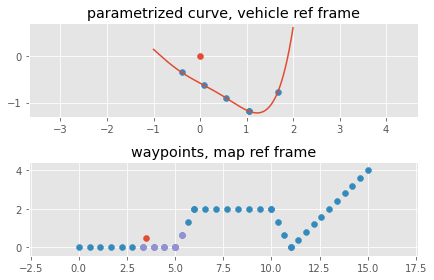

In [13]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

x=np.arange(-1,2,0.001) #interp range of curve 

# VEHICLE REF FRAME
plt.subplot(2,1,1)
plt.title('parametrized curve, vehicle ref frame')
plt.scatter(0,0)
plt.scatter(wp_vehicle_frame[0,:],wp_vehicle_frame[1,:])
plt.plot(x,[f(xs,coeff) for xs in x])
plt.axis('equal')

# MAP REF FRAME
plt.subplot(2,1,2)
plt.title('waypoints, map ref frame')
plt.scatter(state[0],state[1])
plt.scatter(track[0,:],track[1,:])
plt.scatter(track[0,nn_idx:nn_idx+LOOKAHED],track[1,nn_idx:nn_idx+LOOKAHED])
plt.axis('equal')

plt.tight_layout()
plt.show()
#plt.savefig("fitted_poly")

In [ ]:
def spline_planning(qs, qf, ts, tf, dqs=0.0, dqf=0.0, ddqs=0.0, ddqf=0.0):
    
    bc = np.array([ys, dys, ddys, yf, dyf, ddyf]).T 
    
    C = np.array([[1,    xs,    xs**2,   xs**3,    xs**4,    xs**5],    #f(xs)=ys
                  [0,     1,  2*xs**1, 3*xs**2,  4*xs**3,  5**xs^4],    #df(xs)=dys
                  [0,     0,        1, 6*xs**1, 12*xs**2, 20**xs^3],    #ddf(xs)=ddys
                  [1,    xf,    xf**2,   xf**3,    xf**4,    xf**5],    #f(xf)=yf
                  [0,     1,  2*xf**1, 3*xf**2,  4*xf**3,  5**xf^4],    #df(xf)=dyf
                  [0,     0,        1, 6*xf**1, 12*xf**2, 20**xf^3]])   #ddf(xf)=ddyf
    
    #To compute the polynomial coefficients we solve:
    #Ax = B. 
    #Matrices A and B must have the same number of rows
    a = np.linalg.lstsq(C,bc)[0]
    return a